# Deep Q-Network (DQN) for LunarLander-v2

This notebook is an implementation of a Deep Q-Network to tackle the "LunarLander-v2" environment in OpenAI Gym. The DQN will learn to land a spacecraft safely on the lunar surface. The goal is to achieve an average score of 195 or above over the last 50 episodes.

### Import Libraries

In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import os
import renderlab
import itertools

### Define the Hyperparameters

Setting up hyperparameters like learning rate, batch size, exploration rates, and defining the file path for saving the trained DQN model.

In [2]:
# Define the Parameters
GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_SIZE = 10000
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 0.995
LEARNING_RATE = 0.0005
solved_score = 195 
model_save_path = 'dqn_lunarlander_model.pth'

### Standard DQN Model

Below is the neural network that will approximate the Q-value function. The network will take the state as input and output Q-values for each action.

In [3]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Memory

Using a replay memory to store transitions that the agent observes, allowing to reuse this data later. This helps in breaking the correlation between consecutive learning samples.

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### DQN Agent Class

Encapsulating the learning mechanisms of the DQN agent, including action selection, model optimization, and interaction with the replay memory, along with managing the exploration rate decay.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPS_START

        self.policy_net = DQN(state_size, action_size)
        self.target_net = DQN(state_size, action_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LEARNING_RATE)
        self.memory = ReplayMemory(BUFFER_SIZE)

    def select_action(self, state):
        sample = random.random()
        eps_threshold = self.epsilon
        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1, 1)
        else:
            return torch.tensor([[random.randrange(self.action_size)]], dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < BATCH_SIZE:
            return

        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.tensor(batch.done, dtype=torch.float32)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(BATCH_SIZE)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) * (1 - done_batch) + reward_batch

        loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(EPS_END, EPS_DECAY * self.epsilon)

### Training Loop

Runs the LunarLander-v2 environment for a set number of episodes, gathering experiences and optimizing the agent's policy network based on these experiences.

In [6]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

scores = []
average_scores = []
max_steps_per_episode = 2000  # Maximum steps per episode to prevent very long episodes
solved_score = 195  # Solved condition threshold

# Wrap the episode range with tqdm for the progress bar
for i_episode in itertools.count():
    state_tuple = env.reset()
    state = state_tuple[0] if isinstance(state_tuple, tuple) else state_tuple
    state = torch.from_numpy(state).float().unsqueeze(0)
    total_reward = 0
    done = False
    step_count = 0  # Step counter for each episode

    while not done and step_count < max_steps_per_episode:
        action = agent.select_action(state)
        output = env.step(action.item())
        next_state = output[0]
        reward = output[1]
        done = output[2]

        next_state = torch.from_numpy(next_state).float().unsqueeze(0)
        reward_tensor = torch.tensor([reward], dtype=torch.float)

        agent.memory.push(state, action, next_state, reward_tensor, done)
        state = next_state
        total_reward += reward
        agent.optimize_model()

        step_count += 1

    agent.update_target_net()
    agent.decay_epsilon()
    scores.append(total_reward)

    # Calculate and store the average score every 10 episodes
    if i_episode % 5 == 0:
        # Keep calculating the average over the last 50 episodes
        avg_score = np.mean(scores[-50:])  
        average_scores.append(avg_score)
        print(f"Episode {i_episode}, Average Score: {avg_score}")

    # Check if the environment is solved
    if len(scores) >= 50 and np.mean(scores[-50:]) >= solved_score:
        print("*"*120)
        print(f"Solved at episode: {i_episode} Avg Results: {np.mean(scores[-50:]):.2f}")
        
        # Save the policy network model only when the environment is solved
        torch.save(agent.policy_net.state_dict(), model_save_path)
        print(f"Model successfully saved to {model_save_path}")
        break

env.close()

Episode 0, Average Score: -116.62418785448958
Episode 5, Average Score: -132.39949189223583
Episode 10, Average Score: -171.54100726080893
Episode 15, Average Score: -185.7537530436623
Episode 20, Average Score: -172.79702446701168
Episode 25, Average Score: -170.00303359590356
Episode 30, Average Score: -163.7661281557493
Episode 35, Average Score: -159.37079333212907
Episode 40, Average Score: -154.86361208586035
Episode 45, Average Score: -155.79016332568537
Episode 50, Average Score: -148.91736893725695
Episode 55, Average Score: -142.4927132519197
Episode 60, Average Score: -123.80164491657123
Episode 65, Average Score: -110.85345602613508
Episode 70, Average Score: -104.42840551126841
Episode 75, Average Score: -99.1163268235124
Episode 80, Average Score: -96.35960565777954
Episode 85, Average Score: -91.8079437535802
Episode 90, Average Score: -87.74685226276861
Episode 95, Average Score: -78.12176948609235
Episode 100, Average Score: -78.05239520435663
Episode 105, Average Scor

### Training Progress Visualization

Visualizing the training progress with a plot of the average reward per episode (Y-axis) against the number of episodes (X-axis).

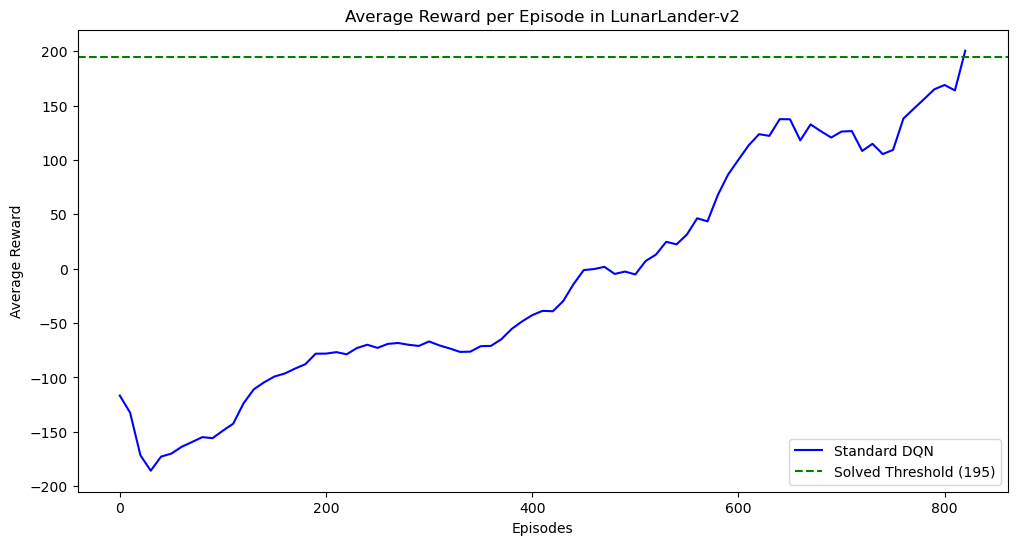

In [13]:
# Determine the number of episodes from the length of average_scores
num_episodes = len(average_scores)

# Generating episode numbers for x-axis
episode_numbers = list(range(0, num_episodes * 10, 10))

# Plotting the graph
plt.figure(figsize=(12, 6))
plt.plot(episode_numbers, average_scores, label='Standard DQN', color='blue')
plt.axhline(y=solved_score, color='g', linestyle='--', label='Solved Threshold (195)')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward per Episode in LunarLander-v2')
plt.legend()
plt.show()

In [15]:
# Initialize the environment
env = gym.make('LunarLander-v2', render_mode='rgb_array')

# Wrap the environment with RenderFrame from renderlab to record video
env = renderlab.RenderFrame(env, "./video")

# Initialize your DQN agent here (make sure it's trained)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
agent.policy_net.load_state_dict(torch.load(model_save_path))

# Reset the environment and get the initial observation
obs, info = env.reset()

while True:
    # Convert the observation to a tensor and pass it to the agent to select an action
    obs_tensor = torch.from_numpy(obs).float().unsqueeze(0)
    action = agent.select_action(obs_tensor).item()

    # Take the action in the environment
    obs, reward, terminated, truncated, info = env.step(action)

    # Check if the episode is done
    if terminated or truncated:
        break

# Play the recorded video
env.play()

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4
